# Do small share of police really draw a third of complaints?
https://www.ft.com/content/141182fc-7727-4af8-a555-5418fa46d09e

    
The FT article from 2012 claimed police complaints in various US cities were disproportionally concentrated among the top 10% of police officers with the most complaints. During my internship in the summer 2022 I was asked to replicate these findings using a dataset on police complaints in London MET. The code below will demonstrate the statistical reasons for why it is impossible to drawn these kinds of conclusions from this type of data.


![title](https://raw.githubusercontent.com/veronikasamborska1994/data_analysis_example_OWD/master/figures/FT_2021.png)


In [13]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from utils import *
%matplotlib inline
default_plotting_params()

### Load data on Metropolitan Police complaints between 2017-2022 obtained under a freedom of information request by the reporters at FT

Note that without doing any further analyses we can already quickly see a major issue with this dataset. The data file contains 2 columns: case reference, the id of the officer involved. There is no information on the number of cases that each officer had worked on. This means that some officers might receive more complaints than others simply because they work on more cases, and not because they are more likely to receive a complaint. 





In [14]:
case_ref, officer_id = load_police_data()

## Data Inspection Step

First, as a sanity check we will just visualise the data to make sure there are no issues that stand out. The function inspect_data in utils.py orders the officers based on how many complaints they received. After simply plotting each officer's total number of complaints we can see that there is a very unrealistic outlier with over 8000 complaints over the past 5 years. This means subject 122060 was on average receiving 4 complaints per day for the past 5 years which seems impossible. The second most complained officer ID is called 'Organisational', which is unlikely to refer to a single officer. We will therefore exclude these officer IDs from the rest of the analysis.

subject 122060 has an average of 4 complaints per day
Organisational has an average of 0.24 complaints per day


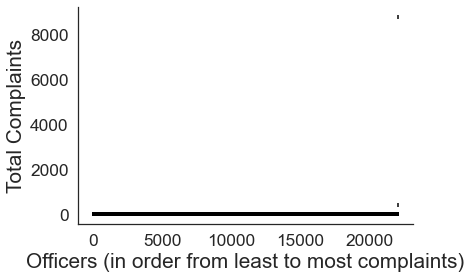

In [3]:
sorted_cases, sorted_ids  = inspect_data(case_ref, officer_id, complaints_per_case)

plt.scatter(np.arange(len(sorted_cases)),sorted_cases, color = 'black', marker = "|", s = 10); sns.despine()
plt.xlabel('Officers (in order from least to most complaints)'); plt.ylabel('Total Complaints')

print(str(sorted_ids[-1]) + ' has an average of ' + str(int(sorted_cases[-1]/5/365)) + ' complaints per day')
print(str(sorted_ids[-2]) + ' has an average of ' + str(np.round(sorted_cases[-2]/5/365,2)) + ' complaints per day')

sorted_cases_cl = sorted_cases[:-2]; sorted_ids_cl = sorted_ids[:-2] # exclude the last two subjects


## Grouping officers ranked by the number of complaints into deciles 

Here I will group the MET officers into deciles just like in the original article. It looks like we are more or less replicating the results that top 10% of the officers are drawing a disproportionate amount of complaints. As I already mentioned earlier we do not have a baseline for how many cases each officer worked on so this plot is confounded and should not be interpreted as 'top % of officers are disproportionally more likely to receive complaints'. Although this is unlikely but in the next step let's assume that each officer has a uniform probability of receiving a complaint. 

In MET top 10% of the officers are responsible for 28% of complaints ?


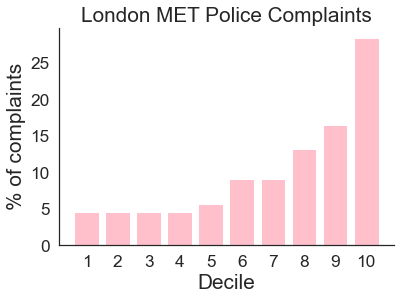

In [4]:
deciles_ = get_decile_data(sorted_cases_cl, sorted_ids_cl)

plt.bar(np.arange(len(deciles_)), deciles_, color = 'pink')
plt.xticks(np.arange(10),np.arange(10)+1); plt.title('London MET Police Complaints')
plt.ylabel( '% of complaints'); plt.xlabel('Decile'); sns.despine()
print('In MET top 10% of the officers are responsible for ' +str(int(deciles_[-1])) + '% of complaints ?')

## Simulation for a case where all officers have an equal probability of receiving a complaint

We can quickly find out that there are [32,493](https://en.wikipedia.org/wiki/Metropolitan_Police) officers at the London MET and from our dataset we can calculate that there were 58147 complaints received in the past 5 years. So on average each year there were 0.36 complaints per officer. With these two numbers we can simulate the simplest case where each officer has an equal probability of receiving a complaint by drawing samples from a Poisson distribution with an expected number of 0.36 per year. 


In [5]:
n_total_officers = 32493;  # from https://en.wikipedia.org/wiki/Metropolitan_Police
tot_complaints = np.sum(complaints_per_case) # total number of complaints 
unif_prob = tot_complaints/n_total_officers/5 # assume each officer has a uniform probability of a complaint (divided by 5 because the data is from the last 5 years)
print('Total # of complaints ' + str(tot_complaints)); print(str(np.round(unif_prob,2)) + ' complaints per officer')   

prob_, deciles_sim = simulate_decile_data(unif_prob, complaints_per_case) 


Total # of complaints 58147
0.36 complaints per officer


## Even if all officers were equally likely to receive a complaint the resulting distribution would look exponential 

In simulated data where all officers have an equal chance of getting a complaint the top decile is responsible for a lower number of complaints than in the real data but the distribution still looks exponential. This suggests that there is a major problem in interpreting these kinds of plots.  

Top 10% of the officers are responsible for 21% of complaints in simulated data


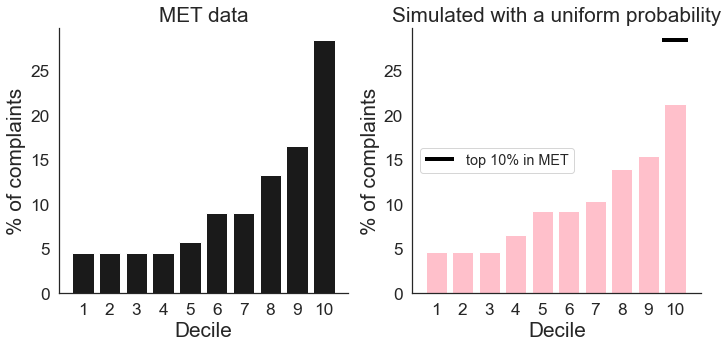

In [15]:
colors = ['k','pink']; titles = ['MET data', 'Simulated with a uniform probability']; max_ = np.max([deciles_,deciles_sim])
plt.figure(figsize = (10,5))
for i, pl in enumerate([deciles_,deciles_sim]):
    plt.subplot(1,2,i+1); plt.bar(np.arange(len(pl)), pl, color = colors[i]); 
    plt.xticks(np.arange(10),np.arange(10)+1);
    plt.ylabel( '% of complaints'); plt.xlabel('Decile');
    plt.title(titles[i])
    sns.despine();
plt.hlines(max_,8.5,9.5, color = 'black', label = 'top 10% in MET', linewidth = 4); plt.legend(loc ='center left', fontsize = 'large')
plt.tight_layout()
print('Top 10% of the officers are responsible for ' +str(int(deciles_sim[-1])) + '% of complaints in simulated data')

## Simulating a case where the probabilities of receiving a comlaint in each decile are proportional to the ratios in % of complaints received in each decile in MET data

Now let's simulate a case where each decile of police officers has a different chance of receiving a complaint. Here the probability distribution is proportional to the distribution of the % of complaints in each decile in the MET data. Officer in the top decile will on average have at least one complaint a year. The resulting simulated distribution starts to match the real data much more closely. This suggests it is in fact possible that some officers are more likely to receive a complaint than others. 

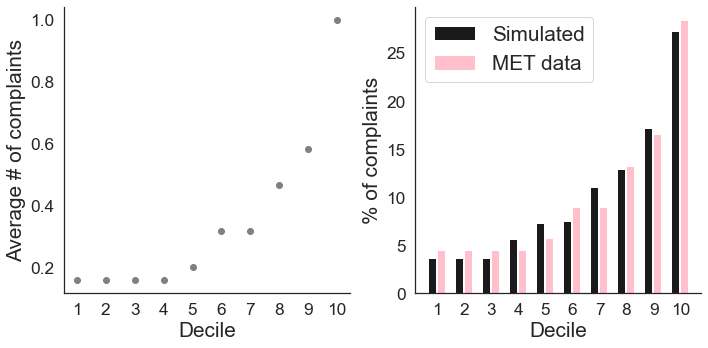

In [16]:
complaint_probs = deciles_/np.max(deciles_) # set the probability distribution to be proportional to the distribution of the % of complaints in each decile in the MET data.

plt.figure(figsize = (10, 5)); plt.subplot(1,2,1)
plt.scatter(np.arange(len(complaint_probs)), complaint_probs, color = 'grey'); plt.xticks(np.arange(10),np.arange(10)+1)
plt.ylabel('Average # of complaints'); plt.xlabel('Decile'); plt.tight_layout()
simulated_, years_to, av  = simulate_non_uniform(complaint_probs, quartiles = 10)
legends = ['Simulated', 'MET data']
colors = ['k','pink'];  plt.subplot(1,2,2)
for i, pl in enumerate([simulated_,deciles_]):
    
    plt.bar(np.arange(len(pl))+i/3, pl, color = colors[i], label = legends[i], width = 0.3); 
    plt.legend()
    plt.ylabel( '% of complaints'); plt.xlabel('Decile'); plt.xticks(np.arange(10)+0.2, np.arange(10)+1)
    sns.despine();plt.tight_layout()

## Major issue

 We can simulate 

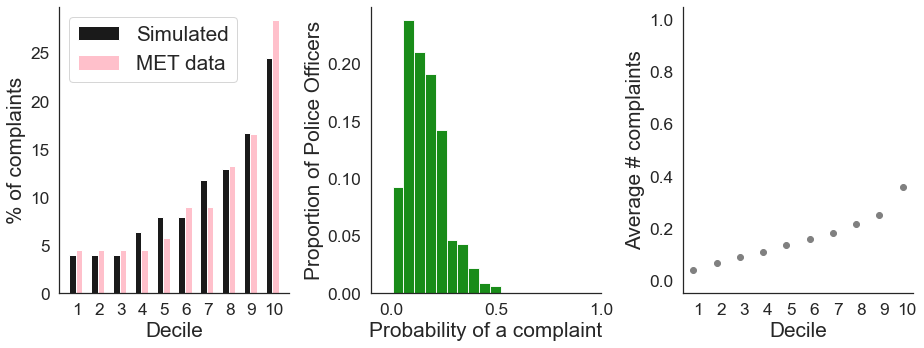

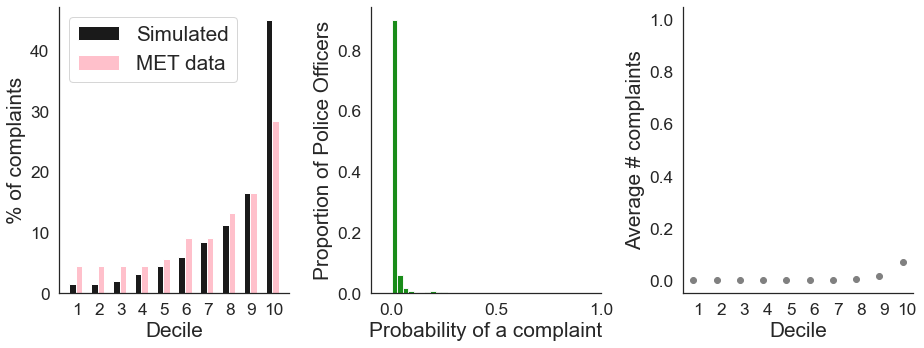

In [8]:
quartiles = int(n_total_officers/100)
a_ex = [2,0.1]; b_ex = [10, 10]
for a,b in zip(a_ex,b_ex):
    lamdas = lambdas_sim_graded(a,b, quartiles)
    yearly_prob = sort_lambdas(lamdas)
    simulated,years_to,av = simulate_non_uniform(lamdas, quartiles)
    fig, ax = plt.subplots(1,3, figsize=(13, 5))
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'k', label = 'Simulated',  width = 0.3)
    ax[0].bar(np.arange(len(deciles_))+0.3, deciles_, color = 'pink', label = 'MET data', width = 0.3)
    ax[0].legend()
    ax[0].set_ylabel( '% of complaints'); ax[0].set_xlabel('Decile'); ax[0].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    weights = np.ones_like(lamdas) / len(lamdas)
    ax[1].hist(lamdas, 10,weights = weights, color = 'green', alpha = 0.9)
    ax[1].set_xlim(-0.1,1)
    ax[1].set_xlabel('Probability of a complaint'); ax[1].set_ylabel('Proportion of Police Officers')
    ax[2].scatter(np.arange(len(yearly_prob)), yearly_prob, color = 'grey');
    ax[2].set_ylabel('Average # complaints'); ax[2].set_xlabel('Decile'); ax[2].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    ax[2].set_ylim(-0.05,1.05)
    plt.tight_layout()
    sns.despine()

## Interactive

The widget below allows you to play around with various gamma probability distributions

In [9]:
@widgets.interact(a = (1,10),b = (1, 10))
def plot(a = 0.1, b = 2):
    quartiles = int(n_total_officers/100)
    lamdas = lambdas_sim_graded(a,b, quartiles)
    yearly_prob = sort_lambdas(lamdas)
    simulated, years_to,av = simulate_non_uniform(lamdas, quartiles)
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'k', label = 'Simulated',  width = 0.3)
    ax[0].bar(np.arange(len(deciles_))+0.3, deciles_, color = 'pink', label = 'MET data', width = 0.3)
    ax[0].legend()
    ax[0].set_ylabel( '% of complaints'); ax[0].set_xlabel('Decile'); ax[0].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    weights = np.ones_like(lamdas) / len(lamdas)
    ax[1].hist(lamdas,weights = weights, color = 'green', alpha = 0.9)
    ax[1].set_xlim(-0.1,1)
    ax[1].set_xlabel('Probability of Getting a Complaint'); ax[1].set_ylabel('Proportion of Police Officers')
    ax[2].scatter(np.arange(len(yearly_prob)), yearly_prob, color = 'grey');
    ax[2].set_ylabel('Average # of complaints'); ax[2].set_xlabel('Decile'); ax[2].set_xticks(np.arange(10)+0.2,np.arange(10)+1)
    
    ax[2].set_ylim(-0.05,1.05)
    sns.despine(); plt.tight_layout()
    

    print("Top Decile Responsible for " + str(np.round(simulated[-1],1)) + '%')
    print('Number of Years to Achieve Total --> ' + str(years_to))
    print('Average % of complaints per officer ' + str(np.round(av,3))+ '%')

    


interactive(children=(IntSlider(value=1, description='a', max=10, min=1), IntSlider(value=2, description='b', …

In [12]:
prms = np.arange(0.1, 20, 0.1);
decile_responsible, average_complaints, years_to_total, labmdas_dec = simulate_lambdas(prms)


100%|██████████| 39601/39601 [56:52<00:00, 11.61it/s]  


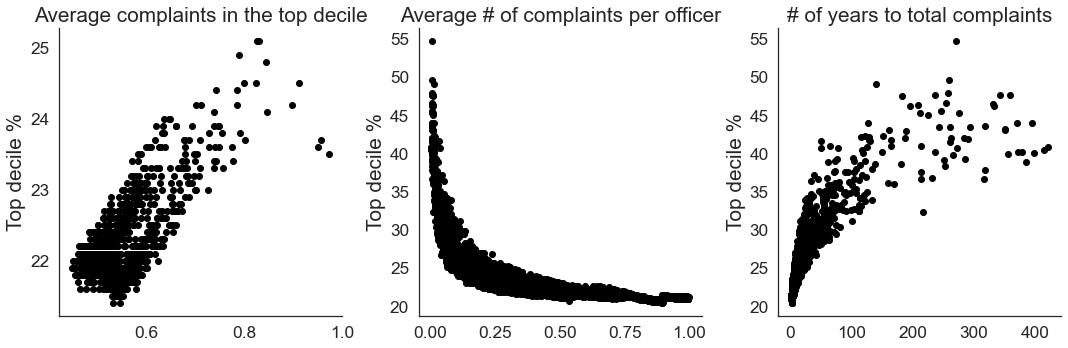

In [11]:
# Selecting average complaints between 0.35 and 0.37 and # of years to complaint to be equal to 5
ind_av = np.intersect1d(np.where(average_complaints > 0.3)[0], np.where(average_complaints < 0.4)[0])
ind_year = np.intersect1d(np.where(years_to_total > 3)[0], np.where(years_to_total < 7)[0])
year_av_data = np.intersect1d(ind_av,ind_year)
select_prop = labmdas_dec[year_av_data]; select_dec = decile_responsible[year_av_data]


plt.figure(figsize = (15,5))
titles = ['Average complaints in the top decile', 'Average # of complaints per officer', '# of years to total complaints']
xlabel = ['Average complaints', 'Average complaints', '# Years']
for i,pl in enumerate([select_prop,average_complaints, years_to_total]):
    plt.subplot(1,3,i+1)
    if i == 0:
        plt.scatter(pl[:,-1], select_dec, color = 'black');
    else:
        plt.scatter(pl, decile_responsible, color = 'black');
        
    sns.despine()
    plt.title(titles[i])
    plt.ylabel('Top decile %')
    plt.tight_layout()
